In [20]:
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import bqplot
from palettable.colorbrewer.diverging import *

In [2]:
sns.set(rc={'figure.figsize':(8,6)})
sns.set_style("white")

In [5]:
df_raw = pd.read_csv('./data/train_flatten_with_ts.csv', index_col=0)
df_raw = df_raw.drop('Unnamed: 0.1', axis=1)

In [6]:
df_raw.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime',
       'bounces', 'hits', 'newVisits', 'pageviews', 'transactionRevenue',
       'visits', 'browser', 'deviceCategory', 'isMobile', 'operatingSystem',
       'adContent', 'adwordsClickInfo', 'campaign', 'isTrueDirect', 'keyword',
       'medium', 'referralPath', 'source', 'city', 'continent', 'country',
       'metro', 'networkDomain', 'region', 'subContinent', 'last_session_1',
       'next_session_1'],
      dtype='object')

## Geographic features

### Continent

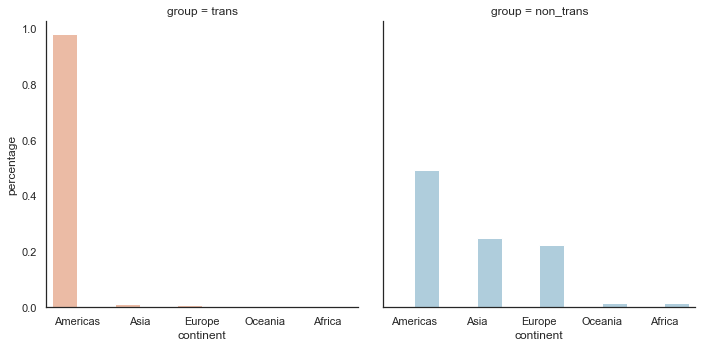

In [160]:
bar_continent_trans = df_raw[df_raw.transactionRevenue > 0].groupby(
    df_raw.continent).size().sort_values(ascending=False).head(5)
bar_continent_nontrans = df_raw[pd.isnull(df_raw.transactionRevenue)].groupby(
    df_raw.continent).size().sort_values(ascending=False).head(5)
df_bar = pd.concat([bar_continent_trans.rename("trans")/sum(df_raw.transactionRevenue > 0),
                    bar_continent_nontrans.rename("no_trans")/sum(pd.isnull(df_raw.transactionRevenue))], axis=1)
df_bar.reset_index(drop=False, inplace=True)
tidy = pd.melt(df_bar.reset_index(),
               id_vars=['continent'], value_vars=["trans", "non_trans"],
               value_name='percentage', var_name='group')

g = sns.catplot(x="continent", y="percentage", hue="group",
                col="group", data=tidy,
                kind='bar', palette="RdBu")
g.savefig("Continent_Raw_Pair.png")

## Traffic 

### Traffic Source

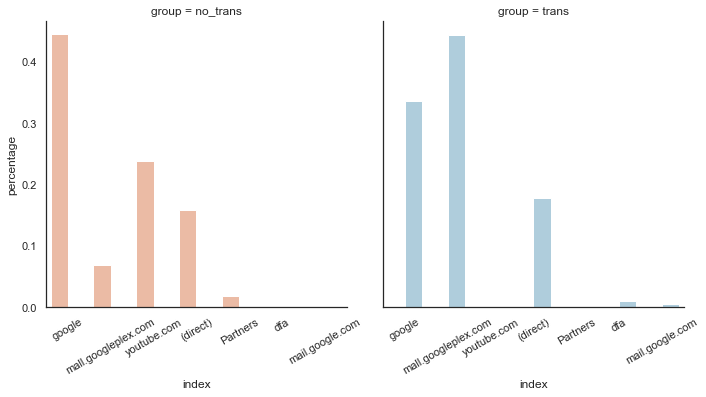

In [163]:
bar_source_trans = df_raw[df_raw.transactionRevenue > 0].groupby(
    df_raw.source).size().sort_values(ascending=False).head(5)
bar_source_nontrans = df_raw[pd.isnull(df_raw.transactionRevenue)].groupby(
    df_raw.source).size().sort_values(ascending=False).head(5)

df_bar = pd.concat([bar_source_trans.rename("trans")/sum(df_raw.transactionRevenue > 0), 
                      bar_source_nontrans.rename("no_trans")/sum(pd.isnull(df_raw.transactionRevenue))], axis=1)
df_bar.reset_index(drop=False,inplace=True)
tidy = pd.melt(df_bar.reset_index(),
               id_vars=['index'], value_vars=["trans","no_trans"],
               value_name='percentage',var_name='group')
tidy = tidy.fillna(0)
tidy = tidy.sort_values(by = 'percentage', ascending=False)

g = sns.catplot(x="index", y="percentage", hue="group",
                col="group", data=tidy,
                kind = 'bar', palette="RdBu")
g.set_xticklabels(rotation=30)
g.savefig("Source_Raw_Pair.png")

### Chrome

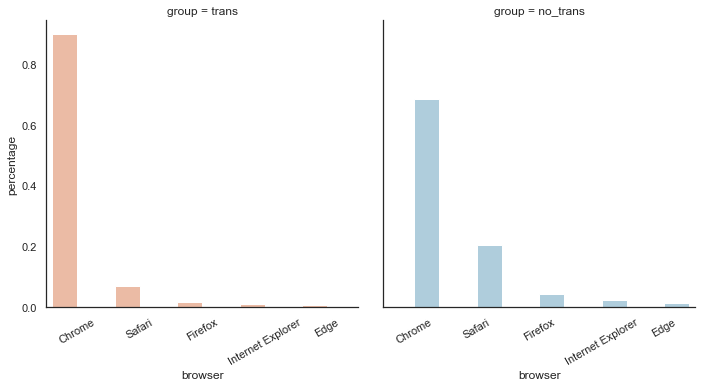

In [171]:
bar_browser_trans = df_raw[df_raw.transactionRevenue > 0].groupby(
    df_raw.browser).size().sort_values(ascending=False).head(5)
bar_browser_nontrans = df_raw[pd.isnull(df_raw.transactionRevenue)].groupby(
    df_raw.browser).size().sort_values(ascending=False).head(5)

df_bar = pd.concat([bar_browser_trans.rename("trans")/sum(df_raw.transactionRevenue > 0), 
                      bar_browser_nontrans.rename("no_trans")/sum(pd.isnull(df_raw.transactionRevenue))], axis=1)
df_bar.reset_index(drop=False,inplace=True)
tidy = pd.melt(df_bar.reset_index(),
               id_vars=['browser'], value_vars=["trans","no_trans"],
               value_name='percentage',var_name='group')
#tidy = tidy.fillna(0)
tidy = tidy.sort_values(by = 'percentage', ascending=False)

g = sns.catplot(x="browser", y="percentage", hue="group",
                col="group", data=tidy,
                kind = 'bar', palette="RdBu")
g.set_xticklabels(rotation=30)
g.savefig("browser_Raw_Pair.png")

## Visitor Time Features
### visitStartTime

- **visitStartTime** is defined as POSIX time in Google Analytics schema, which means number of seconds since epoch. BigQuery TIMESTAMP is encoded as number of microseconds since epoch. 
- 'The timestamp (expressed as POSIX time)' and as such it is expressed in UTC.       
          
- On the other hand **date** (or ga:date to be more specific) comes from Google Analytics and it is expressed on the timezone that the GA administrator has configured in the specific view's settings. 
- In layman terms, it is a property of the website, not the client/web browser and it should be consistent in all rows if they came from the same view irrespectively of the timezone of the visitor.   
- That being said, and knowing that the data come from Google Merchandise Store which resides in California (which is UTC -7), every session started between 00:00 and 07:00 it is accounted in the previous day "date wise" and to the next day "visitStartTime wise".

In [172]:
df_raw['visitTime'] = pd.to_datetime(
    df_raw['visitStartTime'], unit='s')

In [173]:
df_raw['weekday'] = df_raw['visitTime'].dt.weekday
df_raw['month'] = df_raw['visitTime'].dt.month
df_raw['year'] = df_raw['visitTime'].dt.year
df_raw['hour'] = df_raw['visitTime'].dt.hour

In [174]:
df_t_trans = df_raw.loc[df_raw.transactionRevenue > 0,]
df_t_ntrans = df_raw.loc[pd.isnull(df_raw.transactionRevenue),:]

#### For hour

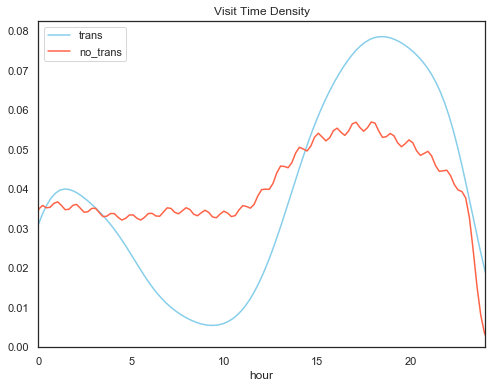

In [180]:
g = sns.distplot( df_t_trans['hour'] , bins = None, color="skyblue", label="trans", hist = False)
g = sns.distplot( df_t_ntrans['hour'] , bins = None, color="tomato", label="no_trans", hist = False)
g.set(xlim=(0,24))
plt.legend()
plt.title("Visit Time Density")
g.figure.savefig("raw_visit_time_density.png")